<a href="https://colab.research.google.com/github/nandeeswarbadugu/Pytorch/blob/main/workflow_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning is all about
1. Create DataSets
2. Pick or Build Model
3. Evaluate Model


What we're going to cover
In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

a pytorch workflow flowchat


In [49]:
# Specifically, we're going to cover:

# Topic	Contents
# 1. Getting data ready	Data can be almost anything but to get started we're going to create a simple straight line
# 2. Building a model	Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
# 3. Fitting the model to data (training)	We've got data and a model, now let's let the model (try to) find patterns in the (training) data.
# 4. Making predictions and evaluating a model (inference)	Our model's found patterns in the data, let's compare its findings to the actual (testing) data.
# 5. Saving and loading a model	You may want to use your model elsewhere, or come back to it later, here we'll cover that.
# 6. Putting it all together	Let's take all of the above and combine it.


In [50]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

1. Data (preparing and loading)


In [51]:
weight = 0.7
bias = 0.2

# Create Data
start  = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2140],
         [0.2280],
         [0.2420],
         [0.2560],
         [0.2700],
         [0.2840],
         [0.2980],
         [0.3120],
         [0.3260]]))

Now we're going to move towards building a model that can learn the relationship between X (features) and y (labels).


Split data into training and test sets

we are not using validation test here



In [52]:
split_percent = int(0.8 * len(X))
X_train, y_train = X[:split_percent], y[:split_percent]
X_test, y_test = X[split_percent:], y[split_percent:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Till now we only have data we are not using it for anything let's visualize it on

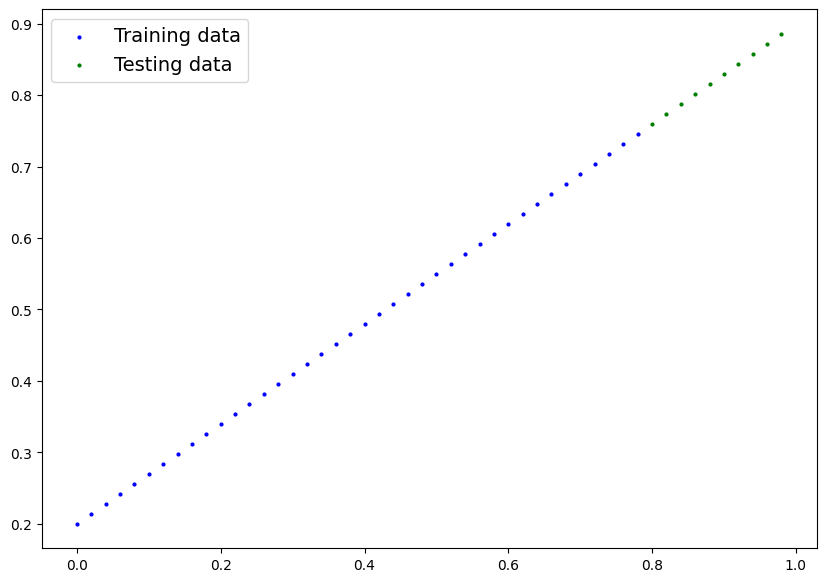

In [53]:
def plot_data(train_data = X_train,
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test,
              predictions = None):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c = "b", s = 4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_data()

2. Earlier we had created Data & Plotted it to visualize Now we will build model but not train it

In [54]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.weights = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad= True)
      self.bias = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)
      print(f"from model {self.weights}")

  def forward(self, X : torch.Tensor) -> torch.Tensor:
    return self.weights * X + self.bias

We'll be using Python classes to create bits and pieces for building neural networks. If you're unfamiliar with Python class notation, I'd recommend reading Real Python's Object Orientating programming in Python 3 guide a few times.

In [55]:
# Checking contents of pytorch model

torch.manual_seed(100)

model_0 = LinearRegressionModel()

list(model_0.parameters())

from model Parameter containing:
tensor([0.3607], requires_grad=True)


[Parameter containing:
 tensor([0.3607], requires_grad=True),
 Parameter containing:
 tensor([-0.2859], requires_grad=True)]


We can also get the state (what the model contains) of the model using .state_dict().

In [56]:

# List named parameters
model_0.state_dict()


OrderedDict([('weights', tensor([0.3607])), ('bias', tensor([-0.2859]))])


Making predictions using torch.inference_mode()

In [57]:
with torch.inference_mode():
  y_preds = model_0(X_test)

In [58]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.0026],
        [0.0098],
        [0.0170],
        [0.0242],
        [0.0315],
        [0.0387],
        [0.0459],
        [0.0531],
        [0.0603],
        [0.0675]])


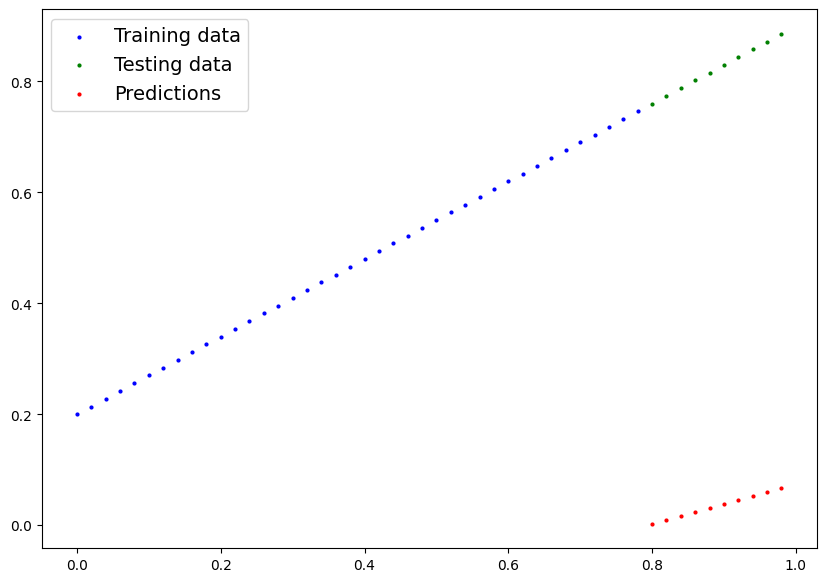

In [59]:
plot_data(predictions=y_preds)

3. Train model
Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

We could hard code this (since we know the default values weight=0.7 and bias=0.3) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.

Creating a loss function and optimizer in PyTorch
For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.

In [60]:
loss_fn = nn.L1Loss()

# optimizer

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [61]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  # Training

  # Put model in training mode (this is the default state of a model)
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)
  # print(y_pred)

  # 2. Calculate the loss (how different are our models predictions to the ground truth)
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()


  # Testing

  # Put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():

    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if epoch %10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")





Epoch: 0 | MAE Train Loss: 0.6182652711868286 | MAE Test Loss: 0.7744663953781128 
Epoch: 10 | MAE Train Loss: 0.5030553936958313 | MAE Test Loss: 0.639756441116333 
Epoch: 20 | MAE Train Loss: 0.3878454267978668 | MAE Test Loss: 0.5050464868545532 
Epoch: 30 | MAE Train Loss: 0.27263545989990234 | MAE Test Loss: 0.3703365921974182 
Epoch: 40 | MAE Train Loss: 0.15742547810077667 | MAE Test Loss: 0.23562665283679962 
Epoch: 50 | MAE Train Loss: 0.04504556208848953 | MAE Test Loss: 0.10451464354991913 
Epoch: 60 | MAE Train Loss: 0.023052919656038284 | MAE Test Loss: 0.05672663450241089 
Epoch: 70 | MAE Train Loss: 0.01942858286201954 | MAE Test Loss: 0.04435061663389206 
Epoch: 80 | MAE Train Loss: 0.015999123454093933 | MAE Test Loss: 0.036765046417713165 
Epoch: 90 | MAE Train Loss: 0.012563762255012989 | MAE Test Loss: 0.028492575511336327 


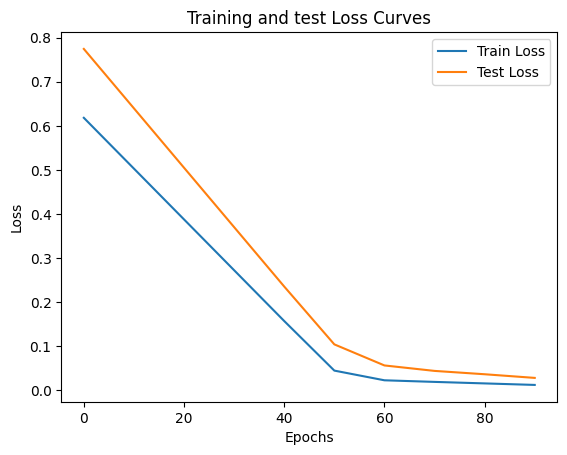

In [62]:
# Plot the bot the loss

plt.plot(epoch_count, train_loss_values, label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.title("Training and test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

Nice! The loss curves show the loss going down over time. Remember, loss is the measure of how wrong your model is, so the lower the better.

But why did the loss go down?

Well, thanks to our loss function and optimizer, the model's internal parameters (weights and bias) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's .state_dict() to see how close our model gets to the original values we set for weights and bias.

In [64]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6546])), ('bias', tensor([0.2191]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.2
